# Подключение к Google Disk

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip -q /content/gdrive/MyDrive/deep\ learning\ school/train.zip -d train
!unzip -q /content/gdrive/MyDrive/deep\ learning\ school/testset.zip -d test

In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Mon Nov 21 15:07:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [ ]:
import matplotlib

In [ ]:
a = ['DejaVu Sans', 'Bitstream Vera Sans', 'Computer Modern Sans Serif', 'Lucida Grande', 'Verdana', 'Geneva', 'Lucid', 'Arial', 'Helvetica', 'Avant Garde', 'sans-serif']

In [ ]:
print(matplotlib.rcParams['font.sans-serif'])

['DejaVu Sans', 'Bitstream Vera Sans', 'Computer Modern Sans Serif', 'Lucida Grande', 'Verdana', 'Geneva', 'Lucid', 'Arial', 'Helvetica', 'Avant Garde', 'sans-serif']


In [ ]:
matplotlib.rcParams['font.sans-serif'] = a[2]

Text(0.5, 0.5, '1')

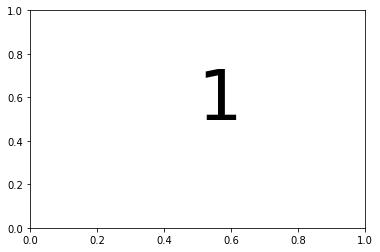

In [ ]:
matplotlib.pyplot.annotate('1', xy=(0.5,0.5), size=70)

# Загрузка датасета

In [ ]:
import os
import random

import pickle
import numpy as np
import pandas as pd
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import WeightedRandomSampler
import torch
from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from collections import Counter
from torchvision import datasets, transforms

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

Зафиксируем рандомное состояние

In [ ]:
SEED = 10
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda") if torch.cuda.is_available() else 'cpu'

Загрузим данные, посмотрим на них

In [ ]:
TRAIN_DIR = Path('train/train/simpsons_dataset')
TEST_DIR = Path('test/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

train_val_labels = [path.parent.name for path in train_val_files]

In [ ]:
lem = pd.Series(train_val_labels).value_counts().sort_values().to_frame("count")

In [ ]:
lem = lem.iloc[16:25, :]

In [ ]:
lem

,count
carl_carlson,98
selma_bouvier,103
barney_gumble,106
groundskeeper_willie,121
maggie_simpson,128
waylon_smithers,181
mayor_quimby,246
lenny_leonard,310
nelson_muntz,358


Сбалансируем данные, используя аугументацию

In [ ]:
augmentations = transforms.RandomChoice([
        transforms.Compose([
          transforms.CenterCrop(size=300),
          transforms.RandomCrop(250),
    ]),
    transforms.ColorJitter(brightness=0.3),
    transforms.RandomRotation(degrees=(-25, 25)),
    transforms.RandomHorizontalFlip(p=1),
])
train_transforms = transforms.Compose([
    augmentations,
    transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
    transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
])
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transforms)

Разделим на тестовую и валидационную выборки

In [ ]:
train_datas, valid_datas = train_test_split(list(range(len(train_dataset))), train_size=0.8)
dataset = {
    'train': torch.utils.data.Subset(train_dataset, train_datas),
    'valid': torch.utils.data.Subset(train_dataset, valid_datas)
}

Тестовый набор данных

In [ ]:
test_transforms = transforms.Compose([
    transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
    transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
])
test_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transforms)

Функция для отрисовки картинок

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
train_loader = DataLoader(dataset["train"], batch_size=16)

Посмотрим на датасет с аугументацией

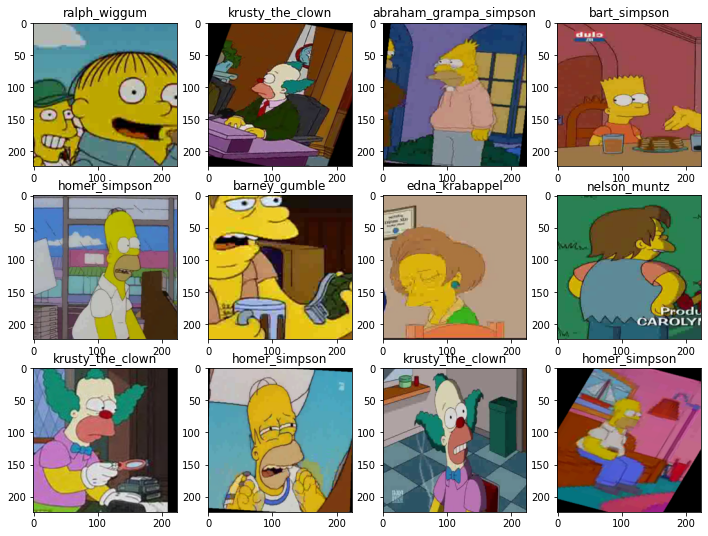

In [ ]:
axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 9))[1]
data, labels = next(iter(train_loader))
for ax, d, l in zip(axes.flatten(), data, labels):
    imshow(d.data.cpu(), title=train_dataset.classes[l], plt_ax=ax)

# Simple CNN

In [ ]:
class First_Simpson_CNN(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.lc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(96 * 5 * 5, 10),


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)


        logits = self.lc(x)
        return logits

Функции для train и predict с сохранением лучшего результата

In [ ]:
def fit_epoch(model, train_loader, criterion, scheduler, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    model.train()

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
    scheduler.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

def eval_epoch(model, val_loader, criterion):
      model.eval()
      running_loss = 0.0
      running_corrects = 0
      processed_size = 0

      for inputs, labels in val_loader:
          inputs = inputs.to(DEVICE)
          labels = labels.to(DEVICE)

          with torch.set_grad_enabled(False):
              outputs = model(inputs)
              loss = criterion(outputs, labels)
              preds = torch.argmax(outputs, 1)

          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)
          processed_size += inputs.size(0)
      val_loss = running_loss / processed_size
      val_acc = running_corrects.double() / processed_size

      return val_loss, val_acc

def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs


def train(train_dataset, scheduler, opt, model, epochs, batch_size):
    random.seed(10)
    # train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} "\
    # val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        criterion = nn.CrossEntropyLoss()
        best_model_wts = model.state_dict()
        best_acc = 0.0

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, scheduler, opt)
            print("loss", train_loss)

            # val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            # history.append((train_loss, train_acc, val_loss, val_acc))
            if train_acc > best_acc:
                best_acc = train_acc
                best_model_wts = model.state_dict()


            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                          #  v_loss=val_loss, t_acc=train_acc, v_acc=val_acc
                                           ))


    model.load_state_dict(best_model_wts)
    print('Best val Acc: {:4f}'.format(best_acc))
    return model, history

In [ ]:
n_classes = len(np.unique(train_val_labels))

In [ ]:
train_dataset = dataset['train']
val_dataset = dataset['valid']

После всех экспериментов было получено, что лучшее качество на SimpleCNN с опимайзером AdamW, bach-size=64, lr~2e-3, к концу 15 эпохи достигло 93%

# Файтюнинг

In [ ]:
import os
from tqdm.autonotebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time

In [ ]:
train_dataset = dataset['train']
val_dataset = dataset['valid']

In [ ]:
model_diff_lr = models.efficientnet_v2_s(pretrained=True)
num_features = 1280
model_diff_lr.classifier = nn.Linear(num_features, n_classes)

optimizer = torch.optim.AdamW(params=[
        {"params": model_diff_lr.classifier.parameters()},
        {"params": model_diff_lr.features.parameters(), "lr": 1e-4}
    ],
    lr=1e-3
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.15)
model_diff_lr.to(DEVICE)

model, hist = train(train_dataset, val_dataset, scheduler, optimizer, model=model_diff_lr, epochs=5, batch_size=64)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


  0%|          | 0.00/82.7M [00:00<?, ?B/s]

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 0.7533372874707286

Epoch 001 train_loss: 0.7533     val_loss 0.1682 train_acc 0.8173 val_acc 0.9558
loss 0.12207861098623358

Epoch 002 train_loss: 0.1221     val_loss 0.1316 train_acc 0.9705 val_acc 0.9668
loss 0.07217718280838939

Epoch 003 train_loss: 0.0722     val_loss 0.1149 train_acc 0.9821 val_acc 0.9737
loss 0.0405951334946823

Epoch 004 train_loss: 0.0406     val_loss 0.0992 train_acc 0.9905 val_acc 0.9759
loss 0.03020105306769321

Epoch 005 train_loss: 0.0302     val_loss 0.0963 train_acc 0.9928 val_acc 0.9761
Best val Acc: 0.976117


In [ ]:
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
probs = predict(model, val_loader)

In [ ]:
preds = [train_dataset.classes[i] for i in probs.argmax(axis=-1)]

In [ ]:
def get_key(d, value):
    for k, v in d.items():
        if v == value:
            return k

In [ ]:
for i in class_count_tr.keys():
    class_correct= class_count_tr[i] - abs(class_count_tr[i] - class_count_p[i])
    class_total = class_count_tr[i]
    print('Accuracy of %5s : %2d %%' % (
        i, 100 * class_correct / class_total))


Accuracy of edna_krabappel : 93 %
Accuracy of homer_simpson : 98 %
Accuracy of sideshow_bob : 99 %
Accuracy of milhouse_van_houten : 99 %
Accuracy of moe_szyslak : 99 %
Accuracy of krusty_the_clown : 100 %
Accuracy of lisa_simpson : 99 %
Accuracy of marge_simpson : 99 %
Accuracy of principal_skinner : 98 %
Accuracy of chief_wiggum : 97 %
Accuracy of nelson_muntz : 97 %
Accuracy of ned_flanders : 97 %
Accuracy of waylon_smithers : 97 %
Accuracy of charles_montgomery_burns : 98 %
Accuracy of bart_simpson : 98 %
Accuracy of barney_gumble : 89 %
Accuracy of apu_nahasapeemapetilon : 100 %
Accuracy of sideshow_mel : 100 %
Accuracy of abraham_grampa_simpson : 100 %
Accuracy of comic_book_guy : 98 %
Accuracy of   gil : 100 %
Accuracy of maggie_simpson : 89 %
Accuracy of agnes_skinner : 100 %
Accuracy of ralph_wiggum : 86 %
Accuracy of kent_brockman : 100 %
Accuracy of lenny_leonard : 100 %
Accuracy of mayor_quimby : 98 %
Accuracy of snake_jailbird : 100 %
Accuracy of martin_prince : 88 %
Accur

In [ ]:
lem.index,

(Index(['lionel_hutz', 'troy_mcclure', 'disco_stu', 'miss_hoover', 'gil',
        'fat_tony', 'otto_mann', 'sideshow_mel', 'agnes_skinner',
        'rainier_wolfcastle', 'cletus_spuckler', 'snake_jailbird',
        'professor_john_frink', 'martin_prince', 'patty_bouvier',
        'ralph_wiggum', 'carl_carlson', 'selma_bouvier', 'barney_gumble',
        'groundskeeper_willie', 'maggie_simpson', 'waylon_smithers',
        'mayor_quimby', 'lenny_leonard', 'nelson_muntz', 'edna_krabappel'],
       dtype='object'),)

In [ ]:
d = [v for i, (k, v) in enumerate(train_dataset.class_to_idx.items()) if k in lem.index]

In [ ]:

s = {d[i]: lem.iloc[i,:].values[0] for i in range(len(lem))}


In [ ]:
s

{3: 98, 5: 103, 14: 106, 18: 121, 21: 128, 24: 181, 29: 246, 36: 310, 41: 358}

In [ ]:
c = {8: 47,
  23: 71,
 31: 72,
 36: 103,
 40: 8}

In [ ]:
all = []
for i, (p, j) in enumerate(train_dataset):
  if j in d:
    all.append(train_dataset[i])

In [ ]:
Counter(c)

Counter({'cletus_spuckler': 8,
         'martin_prince': 23,
         'patty_bouvier': 31,
         'selma_bouvier': 36,
         'troy_mcclure': 40})

In [ ]:
class_count = s
class_weights = {i: 1/c for i, c in class_count.items()}
print(class_weights)
sample_weights = [0] * len(all)
for i, (data, label) in enumerate(tqdm(all)):
    class_weight = class_weights[label]
    sample_weights[i] = class_weight

N = int(max(class_count.values()) * len(class_count))  # fit to max
train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=N_CORES)

{3: 0.01020408163265306, 5: 0.009708737864077669, 14: 0.009433962264150943, 18: 0.008264462809917356, 21: 0.0078125, 24: 0.0055248618784530384, 29: 0.0040650406504065045, 36: 0.0032258064516129032, 41: 0.002793296089385475}


  0%|          | 0/1651 [00:00<?, ?it/s]

In [ ]:
train_dop = DataLoader(all, batch_size=64, sampler=train_sampler)

In [ ]:
len(train_dop)

23

In [ ]:
model, hist = train(train_dop, scheduler, optimizer, model=model, epochs=3, batch_size=64)

epoch:   0%|          | 0/3 [00:00<?, ?it/s]

loss 0.00947183089583394

Epoch 001 train_loss: 0.0095 
loss 0.016469639644299157

Epoch 002 train_loss: 0.0165 
loss 0.020245110305869514

Epoch 003 train_loss: 0.0202 
Best val Acc: 0.998209


# Kaggle

train_dataset - объект imagefolder

In [ ]:
class TestDataset(Dataset):
    def __init__(self, files):
        self.files = files

    def __getitem__(self, index):
        test_transforms = transforms.Compose([
            transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
            transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
        ])
        img = Image.open(self.files[index]).convert('RGB')
        return test_transforms(img)

    def __len__(self):
        return len(self.files)

In [ ]:
test_dataset = TestDataset(test_files)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)

In [ ]:
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transforms)

In [ ]:
preds = [train_dataset.classes[i] for i in probs.argmax(axis=-1)]
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
import pandas as pd

my_submit = pd.read_csv("gdrive/My Drive/deep learning school/sample_submission.csv")
my_submit = pd.DataFrame({'id': test_filenames, 'Expected': preds})
my_submit.head()

,id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv('simple_cnn_baseline.csv', index=False)

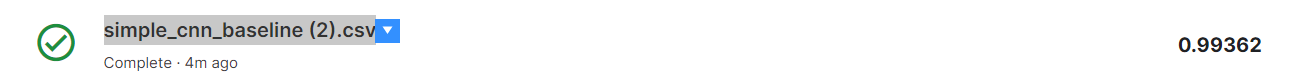

Для достижения лучшего качества можно доучить модель на аугументированных данных и добавить в даталоудер sampler